In [ ]:
pip install -q optax dm-haiku

     |████████████████████████████████| 154 kB 32.6 MB/s 
     |████████████████████████████████| 352 kB 67.9 MB/s 
     |████████████████████████████████| 85 kB 4.8 MB/s 


Due Date: December 7th
# Problem statement

Consider the stochastic cake-eating problem you solved in the previous assignment. Suppose that instead of investing the wealth entirely in the stock market, you have the option to assign a fraction $\alpha$ of your wealth in the stock market, and the remaining is invested in a risk-free savings account that pays a 1.04 % gross return. Notice that $\alpha$ is bounded below by 0, and bounded above by 1.

Solve for the optimal consumption ($c$) and asset allocation ($\alpha$).

- Print the average sum of discounted rewards (utilities) using 1 million simulations.
 
 - Plot the average consumption-wealth ratio ($c / x)$ for each time period $t=0, 1, ..., 49$

 - Plot the average asset allocation in the risky asset($\alpha)$ for each time period $t=0, 1, ..., 49$

Hint: Starting from the code of the previous assignment, the modifications you have to implement are minimal. Namely:

- The output of the neural network now should be a 2d vector, [link text](https://)corresponding to the consumption-wealth ratio (c / x) and $\alpha$, respectively


In [ ]:
import jax
import jax.numpy as jnp
import optax
import haiku as hk
import matplotlib.pyplot as plt


γ = 2.
β = 0.95
Rf = 1.04


def U(c):
    return c**(1 - γ) / (1 - γ)


optimizer = optax.adam
lr = 1e-3
T = 50
batch_size = 200
N = 10000  


def nnet(x):
  X = jnp.column_stack([x])
  X = hk.Linear(32)(X)
  X = jnp.tanh(X)
  X = hk.Linear(2)(X)
  X = jnp.squeeze(X)
  return X


init, nnet = hk.without_apply_rng(hk.transform(nnet))
rng = jax.random.PRNGKey(0)
Θ = init(rng, jnp.array(1.))


opt_state = optimizer(lr).init(Θ)


def stock_return(rng, path):
  μs = 0.06
  σs = 0.2
  ε = jax.random.normal(rng, (path,))
  log_return = μs + σs * ε
  return jnp.exp(log_return).squeeze()


def L(Θ, path, rng):

  x = jnp.ones((path))
  G = 0.

  rng_vector = jax.random.split(rng, T)
  state = x
  inputs = jnp.arange(T), rng_vector

  def core(state, inputs):
    t, rng = inputs
    xt = state
    ct, α = jnp.hsplit(nnet(Θ, xt), 2)

    ct = jax.nn.sigmoid(ct.squeeze() - 4.)* xt
    α = jax.nn.sigmoid(α.squeeze() - 4.)
    ut = U(ct)
    savings = xt - ct

    R = stock_return(rng, path)
    x_tp1 = R * savings * α + Rf * savings * (1 - α)

    state = x_tp1
    discounted_utility = β**t * ut
    return state, discounted_utility.mean()

  state, discounted_utility = jax.lax.scan(core, state, inputs)
  G = discounted_utility.sum()
  return -G


@jax.jit
def evaluation(Θ):
  G= L(Θ, 1000000, rng)
  G = -G
  return G


@jax.jit
def update_gradient_descent(Θ, opt_state, rng):
  rng, _ = jax.random.split(rng)
  grad = jax.grad(L)(Θ, batch_size, rng)
  updates, opt_state = optimizer(lr).update(grad, opt_state)
  Θ = optax.apply_updates(Θ, updates)
  return Θ, opt_state, rng


for iteration in range(N):
  Θ, opt_state, rng = update_gradient_descent(Θ, opt_state, rng)
  if iteration % 1000 == 0:
    rng, _ = jax.random.split(rng)
    print(evaluation(Θ))
    
rng, _ = jax.random.split(rng)
print(evaluation(Θ))


-1276.8389
-374.63837
-370.66296
-369.83478
-369.65076
-369.59924
-369.52945
-369.43042
-369.66162
-369.4707
-369.38452


In [ ]:
def ratio(Θ, path, rng):

  x = jnp.ones((path))
  G = 0.

  rng_vector = jax.random.split(rng, T)
  state = x
  inputs = jnp.arange(T), rng_vector

  def core(state, inputs):
    t, rng = inputs
    xt = state
    ct, α = jnp.hsplit(nnet(Θ, xt), 2)

    ct = jax.nn.sigmoid(ct.squeeze() - 4.)* xt
    α = jax.nn.sigmoid(α.squeeze() - 4.)
    ut = U(ct)
    savings = xt - ct

    R = stock_return(rng, path)
    x_tp1 = R * savings * α + Rf * savings * (1 - α)

    state = x_tp1
    discounted_utility = β**t * ut
    return state, (discounted_utility.mean(), (ct/xt).mean(), α.mean())

  state, (discounted_utility, cx_ratio, α_lst) = jax.lax.scan(core, state, inputs)
  G = discounted_utility.sum()
  return -G, (cx_ratio, α_lst)

@jax.jit
def evaluation1(Θ):
  G, (cx_ratio, α_lst) = ratio(Θ, 1000000, rng)
  G = -G
  return G, cx_ratio, α_lst


@jax.jit
def update_gradient_descent(Θ, opt_state, rng):
  rng, _ = jax.random.split(rng)
  grad, (cx_ratio, α_lst) = jax.grad(ratio, has_aux=True)(Θ, batch_size, rng)
  updates, opt_state = optimizer(lr).update(grad, opt_state)
  Θ = optax.apply_updates(Θ, updates)
  return Θ, opt_state, rng


for iteration in range(N):
  Θ, opt_state, rng = update_gradient_descent(Θ, opt_state, rng)
  if iteration % 1000 == 0:
    rng, _ = jax.random.split(rng)
    print(evaluation1(Θ)[0])
    
rng, _ = jax.random.split(rng)
print(evaluation1(Θ)[0])

-369.3557
-369.47333
-369.35913
-369.43445
-369.36734
-369.31036
-369.43643
-369.31332
-369.37396
-369.52786
-369.2724


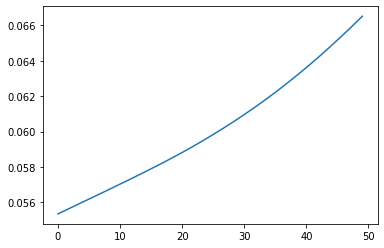

In [ ]:
cx_ratio = evaluation1(Θ)[1]
α_lst = evaluation1(Θ)[2]

plt.plot(cx_ratio)


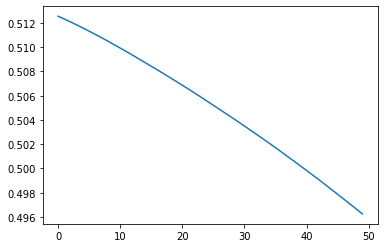

In [ ]:
plt.plot(α_lst)